# IMDB Sentiment Analysis
The project is using the spaCy library to create a sentiment analysis model. The objective is to get familiarized with the spaCy library while creating a model to analyze the sentiments from the reviews of IMDB website.

We will start by importing the relevant modules and data below. 

In [1]:
#Import the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from spacy import tokenizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [2]:
#Import the IMDB data
data = pd.read_csv('IMDB Dataset.csv', header=0)

Let's check the databse to see what it looks like. 

In [3]:
# Check the dataframe to make sure there are no obvious issues
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


We can see above that the dataframe contains 2 columns. The first has the review text and the second shows whether it is a positive or negative review sentiment. Let's ensure these are the only 2 columns by looking at the dataframe structure. 

In [4]:
#Checking the structure of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Both the columns are of object (string) format and contain no missing values. The latter will be confirmed using a sum of the null values in the columns.

In [5]:
#Check to see if the dataframe contains any null values
data.isna().sum()

review       0
sentiment    0
dtype: int64

We can also check the number of duplicated columns below. 

In [6]:
#Check the total number of duplicates in the dataframe
data.duplicated().sum()

418

Let's check to ensure that these are relevant duplicates.

In [7]:
#Visualize the duplicates
data[data.duplicated()]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


Duplicates are likely geniune as the reviews are very specific and unique. Therefore the duplicates will be dropped. 

In [8]:
#Drop the duplicates
data = data.drop_duplicates()

In [9]:
data.duplicated().sum()

0

We should also make sure that the sentiment column only has positive or negative sentiment and not others as well. 

In [10]:
data['sentiment'].nunique()

2

We can see above that there are only 2 unique values in the sentiment column and those relate to 'positive' and 'negative' sentiment. Now that we know that the basic data is clean, we can check the sentiment distribution as a class imbalance can affect the model choice and model generation. 

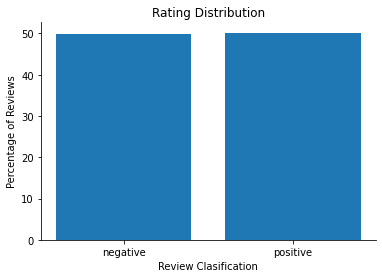

In [11]:
#Check Class imbalance for the sentiment
values, counts = np.unique(data['sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review Clasification')
plt.ylabel('Percentage of Reviews')
sns.despine()
plt.title("Rating Distribution")
plt.show()

We can see that the class is perfectly balanced as this is a kaggle dataset. It is highly unlikely that the data in the real world will require this little cleaning. 

## Preprocessing
Let's start with the preprocessing of the data to make it modelling worthy. The preprocessing will be done using spaCy. Overall the steps to preprocess are:
1. Encode the `sentiment` column;
2. Remove stop words from the reviews;
3. Remove punctuation from the reviews;
4.


### Encode the `sentiment` column
Let's start  with step 1 where the `sentiment` is encoded. We will map '0' for negatvie sentiment and '1' for a positive sentiment, this will be done by creating a dictionary for replacing the terms with the values.

In [12]:
#Create a dictionary that we will use to replace the sentiment strings
sentiment_vector = {"negative":0, "positive":1}

In [13]:
#Replace the sentiment column in place using the replace method
data.replace({"sentiment": sentiment_vector}, inplace=True)

In [14]:
#Ensure the data looks correct
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [15]:
#Ensure that the data type of the sentiment column is correct
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


### Remove stop words from the reviews
Now that we have successfully encoded the `sentiment` column, let's remove the stop words from the `reviews` column. We will use spaCy to do this. 

In [16]:
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")
parser = English()

In [17]:
#Visualize the stopwords
from  spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)
print(stopwords)

['only', 'amount', 'where', 'on', 'name', 'herself', 'before', 'never', 'back', 'down', 'give', 'how', 'the', 'in', '‘s', 'twelve', 'are', 'almost', 'whoever', 'either', 'he', 'neither', 'while', 'would', 'each', 'take', 'must', 'himself', 'when', 'two', 'thereupon', 'eleven', 'such', 'onto', 'which', 'everywhere', 'become', 'to', 'seemed', 'well', 'hereupon', 'and', 'any', 'ours', 'than', 'against', 'you', 'others', 'whereas', 'most', 'whom', 'beyond', 'hereafter', 'anyway', 'also', 'afterwards', '‘d', 'front', 'still', 'n’t', 'even', 'unless', 'serious', "n't", 'seeming', 'otherwise', 'it', 'itself', 'at', "'m", 'all', 'make', 'part', 'doing', 'four', 'them', 'yourselves', 'not', 'she', 'has', 'formerly', 'everything', 'over', 'should', 'hence', 'none', 'about', 'becomes', 'your', 'whereafter', '’ll', 'call', 'out', 'will', 'this', 'few', 'anyone', 'every', 'with', "'ve", 'beforehand', 'please', 'elsewhere', 'show', 'could', 'from', "'ll", 'made', 'quite', 'wherever', 'various', 'acr

In [18]:
len(stopwords)

326

We can see above the stop words and there are 326 potential which will be removed if found in the reviews. 

### Text Cleaning

In [19]:
# Use the punctuations of string module
import string
punctuations = string.punctuation

In [20]:
# Creating a Spacy Parser
from spacy.lang.en import English
parser = English()

In [21]:
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

In [22]:
#Custom transformer using spaCy 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic function to clean the text 
def clean_text(text):     
    return text.strip().lower()

In [23]:
# Vectorization
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer) 
classifier = LinearSVC()

In [24]:
# Using Tfidf
#tfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [25]:
# Features and Labels
X = data['review']
ylabels = data['sentiment']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

In [27]:
# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe = Pipeline([('cleaner', predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(39665,)
(9917,)
(39665,)
(9917,)


In [29]:
# Fit our data
pipe.fit(X_train,y_train)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
# Predicting with a test dataset
sample_prediction = pipe.predict(X_test)

In [ ]:
# Prediction Results
# 1 = Positive review
# 0 = Negative review
for (sample,pred) in zip(X_test,sample_prediction):
    print(sample,"Prediction=>",pred)